In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# for geographical info
# pip install descartes
# conda install geopandas
import descartes
#import geopandas as gpd
#from shapely.geometry import Point, Polygon

In [94]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Part 1: Data Exploration
* First let's get a sense of our data

    - no missing values
    - most of the time records are zeros

In [8]:
print(train.columns)

Index(['RowId', 'IntersectionId', 'Latitude', 'Longitude', 'EntryStreetName',
       'ExitStreetName', 'EntryHeading', 'ExitHeading', 'Hour', 'Weekend',
       'Month', 'Path', 'TotalTimeStopped_p20', 'TotalTimeStopped_p40',
       'TotalTimeStopped_p50', 'TotalTimeStopped_p60', 'TotalTimeStopped_p80',
       'TimeFromFirstStop_p20', 'TimeFromFirstStop_p40',
       'TimeFromFirstStop_p50', 'TimeFromFirstStop_p60',
       'TimeFromFirstStop_p80', 'DistanceToFirstStop_p20',
       'DistanceToFirstStop_p40', 'DistanceToFirstStop_p50',
       'DistanceToFirstStop_p60', 'DistanceToFirstStop_p80', 'City'],
      dtype='object')


In [15]:
train.describe()

,RowId,IntersectionId,Latitude,Longitude,Hour,Weekend,Month,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,...,TimeFromFirstStop_p20,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80
count,8.574090e+05,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,...,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000
mean,2.349039e+06,836.330832,39.657555,-77.900396,12.427463,0.277485,9.104448,1.731272,5.356027,7.681874,...,3.126932,9.051338,12.613628,18.801785,34.037097,6.564450,19.872987,28.255852,43.273503,81.922639
std,2.475128e+05,644.200553,2.920760,5.975814,6.062097,0.447758,1.993233,7.080017,12.861420,15.553418,...,11.631092,20.120829,23.847749,29.399634,40.619387,28.003261,56.564229,71.720090,96.933561,152.682760
min,1.920335e+06,0.000000,33.649970,-87.836750,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.134687e+06,306.000000,39.937600,-84.387710,8.000000,0.000000,7.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.349039e+06,685.000000,39.985810,-75.173270,13.000000,0.000000,9.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,60.400000
75%,2.563391e+06,1254.000000,41.918580,-75.080190,17.000000,1.000000,11.000000,0.000000,0.000000,10.000000,...,0.000000,0.000000,22.000000,31.000000,49.000000,0.000000,0.000000,52.900000,64.100000,85.600000
max,2.777743e+06,2875.000000,42.381780,-71.023520,23.000000,1.000000,12.000000,273.000000,318.000000,343.000000,...,334.000000,347.000000,355.000000,358.000000,359.000000,1902.700000,3099.500000,3099.500000,3581.600000,4064.300000


## How many roads are linked to one intersection?
* take into consideration that some roads might be one way
* so count number of entry and exit separately

In [117]:
roads=train.groupby("IntersectionId")[["EntryStreetName", 'ExitStreetName']].aggregate(lambda x: len(x.unique()))
roads.columns = ["count_entry_streets", "count_exit_streets"]
train=train.merge(roads, left_on = "IntersectionId", right_index = True, how = "left")

In [118]:
train.columns

Index(['RowId', 'IntersectionId', 'Latitude', 'Longitude', 'EntryStreetName',
       'ExitStreetName', 'EntryHeading', 'ExitHeading', 'Hour', 'Weekend',
       'Month', 'Path', 'TotalTimeStopped_p20', 'TotalTimeStopped_p40',
       'TotalTimeStopped_p50', 'TotalTimeStopped_p60', 'TotalTimeStopped_p80',
       'TimeFromFirstStop_p20', 'TimeFromFirstStop_p40',
       'TimeFromFirstStop_p50', 'TimeFromFirstStop_p60',
       'TimeFromFirstStop_p80', 'DistanceToFirstStop_p20',
       'DistanceToFirstStop_p40', 'DistanceToFirstStop_p50',
       'DistanceToFirstStop_p60', 'DistanceToFirstStop_p80', 'City',
       'count_entry_streets', 'count_exit_streets'],
      dtype='object')

## Geo information
* although we already have the cities feature, I want to check if there are roads in between the cities etc. or mislabeled city name in this data. 

* by using K-means method on Longitude and Latitude info, we easily cluster them into four groups, and the graph shows that they are perfectly clustered

* that's great, because this means we don't have to deal with issues like roads between cities etc.

In [27]:
geo_info = train[["Longitude", "Latitude"]]
kmeans = KMeans(n_clusters=4).fit(geo_info)
train["geo_cluster"] = kmeans.labels_

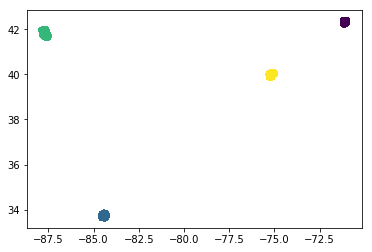

In [33]:
# show cluseters -- 4 different cities
plt.scatter(train.Longitude, train.Latitude, c= train.geo_cluster)

We have much more intersection data for city 2 and 3, less for city 0 and 1

In [79]:
print("number of data for each city: ",train.groupby("geo_cluster")["IntersectionId"].aggregate("count"))
print("number of unique intersection for each city: ",train.groupby("geo_cluster")["IntersectionId"].aggregate(lambda x: len(x.unique())))

number of data for each city:  geo_cluster
0    182050
1    153363
2    133674
3    388322
Name: IntersectionId, dtype: int64
number of unique intersection for each city:  geo_cluster
0     973
1     377
2    2129
3    1317
Name: IntersectionId, dtype: int64


## clusters within the city

can we try to cluster the intersections within the same city?

* looks like this is hard to determine the number of clusters we should use. But we can try different number of clusters later
* future use of this feature: this feature might be helpful to determine the potential traffic of other unseen intersections based on their cluster of the streets. (Alternatively, we can use k-nearest-neighbors for predictions of unseen intersections)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


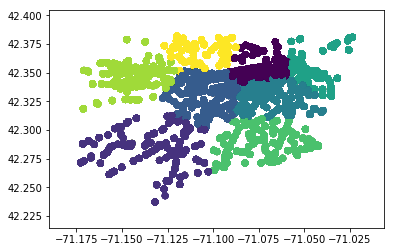

In [88]:
city0 = train[train["geo_cluster"] == 0]
geo_info_city0 = city0[["Longitude", "Latitude"]]
kmeans_city0  = KMeans(n_clusters=8).fit(geo_info_city0)
city0["street_cluster"] = kmeans_city0.labels_
plt.scatter(city0.Longitude, city0.Latitude, c = city0["street_cluster"])
#plt.title = "city 0 streets clusters"

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


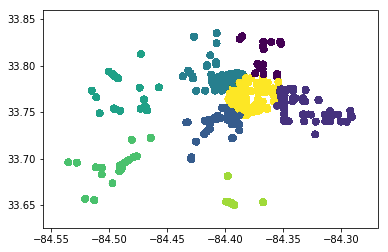

In [89]:
city1 = train[train["geo_cluster"] == 1]
geo_info_city1 = city1[["Longitude", "Latitude"]]
kmeans_city1  = KMeans(n_clusters=8).fit(geo_info_city1)
city1["street_cluster"] = kmeans_city1.labels_
plt.scatter(city1.Longitude, city1.Latitude, c = city1["street_cluster"])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


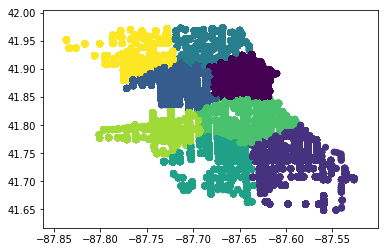

In [90]:
city2 = train[train["geo_cluster"] == 2]
geo_info_city2 = city2[["Longitude", "Latitude"]]
kmeans_city2 = KMeans(n_clusters=8).fit(geo_info_city2)
city2["street_cluster"] = kmeans_city2.labels_
plt.scatter(city2.Longitude, city2.Latitude, c = city2["street_cluster"])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


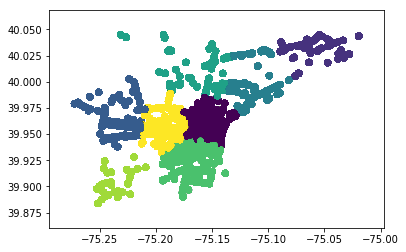

In [93]:
city3= train[train["geo_cluster"] == 3]
geo_info_city3 = city3[["Longitude", "Latitude"]]
kmeans_city3 = KMeans(n_clusters=8).fit(geo_info_city3)
city3["street_cluster"] = kmeans_city3.labels_
plt.scatter(city3.Longitude, city3.Latitude, c = city3["street_cluster"])

## Hours to traffic
For each city, let's look at the average total waiting time (50th percentile) by hours

city 0 at hour0


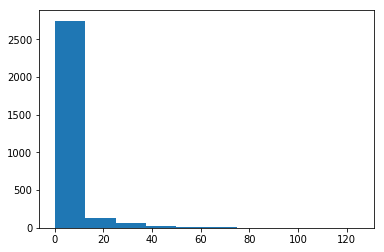

city 0 at hour1


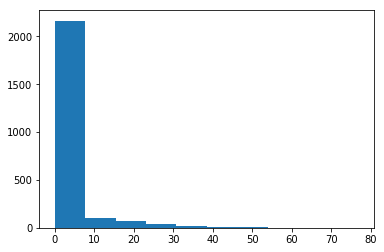

city 0 at hour2


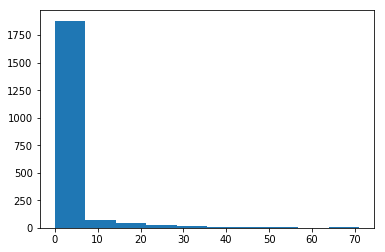

city 0 at hour3


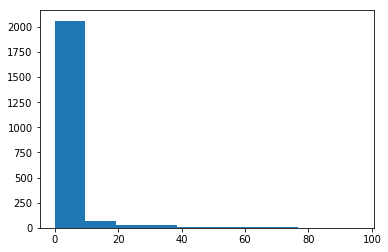

city 0 at hour4


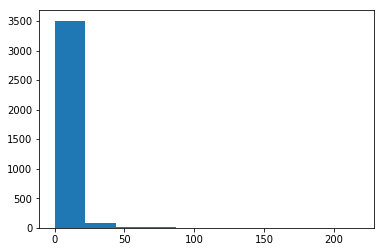

city 0 at hour5


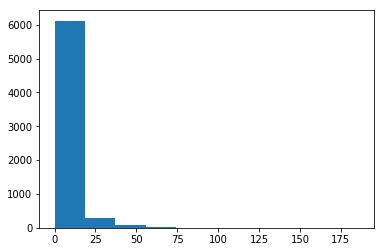

city 0 at hour6


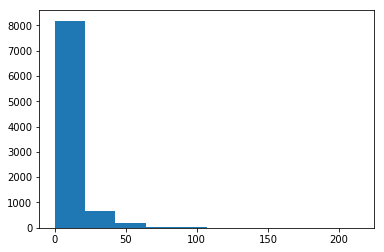

city 0 at hour7


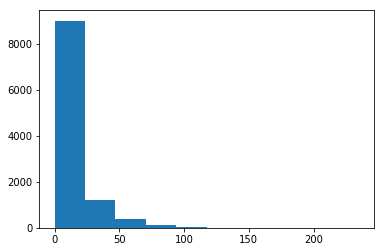

city 0 at hour8


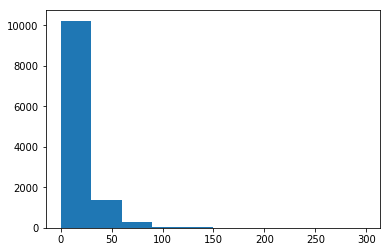

city 0 at hour9


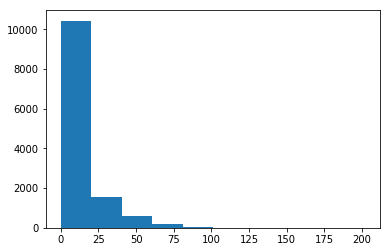

city 0 at hour10


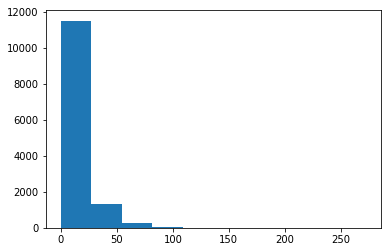

city 0 at hour11


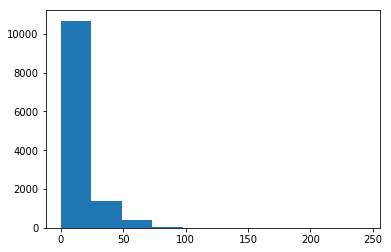

city 0 at hour12


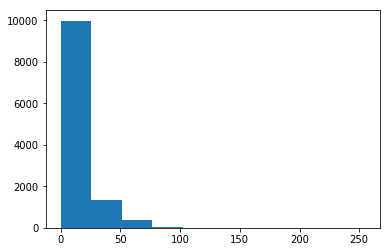

city 0 at hour13


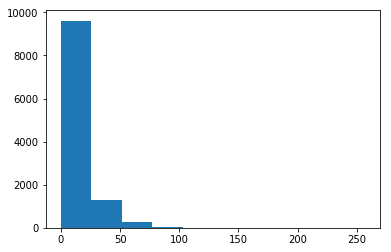

city 0 at hour14


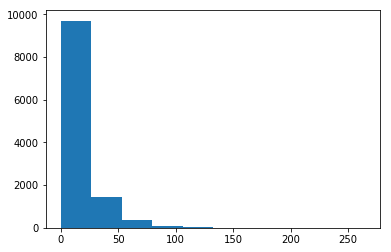

city 0 at hour15


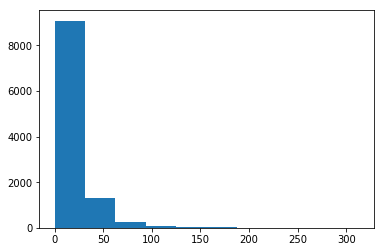

city 0 at hour16


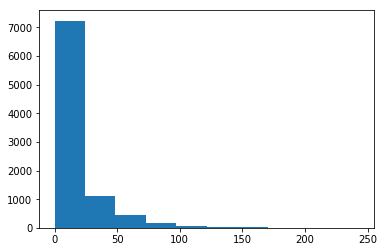

city 0 at hour17


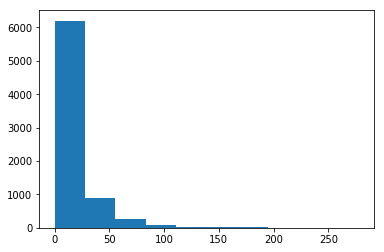

city 0 at hour18


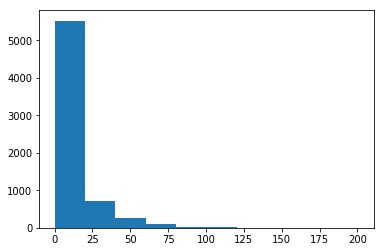

city 0 at hour19


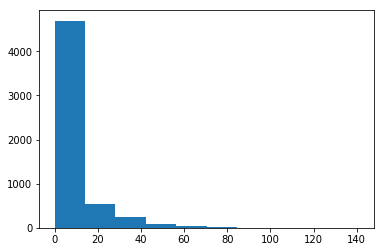

city 0 at hour20


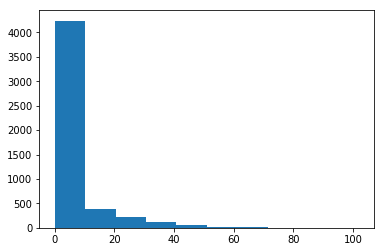

city 0 at hour21


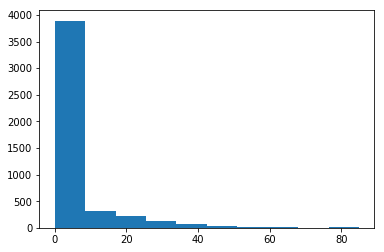

city 0 at hour22


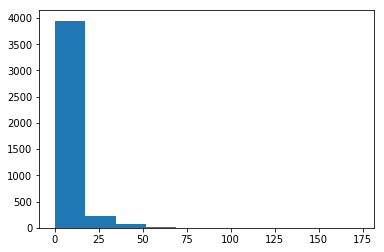

city 0 at hour23


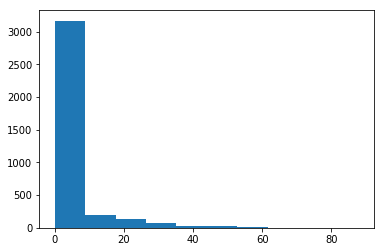

In [46]:
for i in range(24):
    wait_times_0 = train[(train["geo_cluster"] == 0) & (train["Hour"] == i)]["TotalTimeStopped_p50"]
    plt.hist(wait_times_0)
    print('city 0 at hour '+str(i))
    plt.show()

It seems like even with the separation of time, the data is highly unbalanced. So let's try to find the busy street first. By busy, for now we define it as TotalTimeStopped_p20 > 5 and TotalTimeStopped_p50 > 10. 

In [76]:
# helper function for easy visualization later
def busy_streets(city, features_req):
    busy_city = train[(train.geo_cluster == city)]
    for k, v in features_req.items():
        busy_city = busy_city[busy_city[k] > v]
    #print(busy_city.shape)
    print("number of unique busy intercestions in city {} : {}".format(city, len(busy_city.IntersectionId.unique())))
    return busy_city

def busy_streets_by_hour(city, features_req):
    busy_city=busy_streets(city, features_req)
    ls = (busy_city.groupby("Hour")["IntersectionId"].aggregate(lambda ls: len(ls.unique())))
    #print(ls)
    plt.plot(ls, label = "city "+str(city))
    return ls

Separated by hour, how many (unique) intersections are busy?

- suprisingly, even in the mid-night we see streets that are busy

number of unique busy intercestions in city 0 : 679
number of unique busy intercestions in city 0 : 679
number of unique busy intercestions in city 1 : 323
number of unique busy intercestions in city 1 : 323
number of unique busy intercestions in city 2 : 1198
number of unique busy intercestions in city 2 : 1198
number of unique busy intercestions in city 3 : 971
number of unique busy intercestions in city 3 : 971


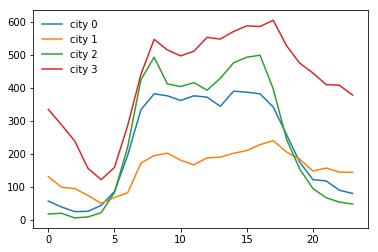

In [77]:
req = {"TotalTimeStopped_p20":5, "TotalTimeStopped_p50":10}
for city in range(4):
    busy_streets(city, req)
    streets = busy_streets_by_hour(city, req)
plt.legend(loc='upper left', frameon=False)

Now we are seeing some differences in cities! City 3 is clearly the busiest at all time. This also corresponds to our observation that we have much more intersection data for city 3 and 2 than city 0 and 1.

Try a more strict definition of "busy", this time we restrict it to be have at least 30 minutes waiting time on average (total wait time 50th percentile > 30)
   - Some interesting observations from the following data and chart:
       - even though for city 0 we only have 973 unique intersections in our data, we see in its peak time, about 1/3 of its intersections are busy. And for city 1 we only have 377, at its peak time about half of them are busy
       - now that we have a stricter definition of 'busy', the number of busy streets are actually getting closer to each other despite the number of total intersections in that city

number of unique busy intercestions in city 0 : 569
number of unique busy intercestions in city 0 : 569
number of unique busy intercestions in city 1 : 291
number of unique busy intercestions in city 1 : 291
number of unique busy intercestions in city 2 : 692
number of unique busy intercestions in city 2 : 692
number of unique busy intercestions in city 3 : 694
number of unique busy intercestions in city 3 : 694


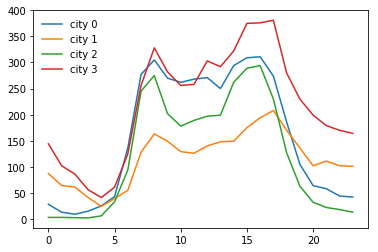

In [81]:
req = {"TotalTimeStopped_p20":5, "TotalTimeStopped_p50":30}
for city in range(4):
    busy_streets(city, req)
    streets = busy_streets_by_hour(city, req)
plt.legend(loc='upper left', frameon=False)

## time from first stop, distance from first stop, total stop time
in this part, we try to understand the relationship between time from first stop, distance from first stop, and our total stop time
* first let's look at the correlation matrix
* the time from first stop is almost perfectly correlated to the total stop time
* the distance from first stop is has a correlation coefficient of ~0.6, which indicates strong correlation as well

In [86]:
corr = train.iloc[:,11:-1].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,TotalTimeStopped_p60,TotalTimeStopped_p80,TimeFromFirstStop_p20,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80
TotalTimeStopped_p20,1,0.78,0.71,0.64,0.54,0.94,0.72,0.66,0.6,0.52,0.67,0.46,0.4,0.35,0.27
TotalTimeStopped_p40,0.78,1,0.94,0.86,0.73,0.78,0.94,0.87,0.8,0.7,0.57,0.59,0.52,0.45,0.36
TotalTimeStopped_p50,0.71,0.94,1,0.92,0.8,0.71,0.9,0.94,0.86,0.75,0.53,0.57,0.56,0.48,0.39
TotalTimeStopped_p60,0.64,0.86,0.92,1,0.87,0.64,0.84,0.89,0.93,0.81,0.48,0.54,0.54,0.51,0.41
TotalTimeStopped_p80,0.54,0.73,0.8,0.87,1,0.54,0.72,0.78,0.84,0.91,0.41,0.47,0.48,0.47,0.44
TimeFromFirstStop_p20,0.94,0.78,0.71,0.64,0.54,1,0.77,0.7,0.64,0.56,0.82,0.58,0.51,0.45,0.35
TimeFromFirstStop_p40,0.72,0.94,0.9,0.84,0.72,0.77,1,0.93,0.85,0.75,0.65,0.78,0.7,0.62,0.5
TimeFromFirstStop_p50,0.66,0.87,0.94,0.89,0.78,0.7,0.93,1,0.92,0.8,0.59,0.73,0.76,0.68,0.55
TimeFromFirstStop_p60,0.6,0.8,0.86,0.93,0.84,0.64,0.85,0.92,1,0.88,0.54,0.68,0.72,0.74,0.62
TimeFromFirstStop_p80,0.52,0.7,0.75,0.81,0.91,0.56,0.75,0.8,0.88,1,0.46,0.59,0.63,0.67,0.71


### Visualize the intersections on Map

In [35]:
#geometry = [Point(xy) for xy in zip(train.Longitude, train.Latitude)]
#gdf = GeoDataFrame(df, geometry=geometry) 